In [1]:
%matplotlib inline
import numpy as np
from scipy import integrate
from scipy.special import gamma
from scipy.optimize import fsolve, basinhopping
import matplotlib.pyplot as plt
import qutip.ipynbtools
from ipywidgets import FloatProgress
import qutip.parallel
from scipy import signal
import scipy.io
import gc
import matplotlib.colors as colors
from IPython.display import clear_output, Javascript, Markdown
import datetime
import math
import uuid
import os
import time
import ipyparallel
import qutip.ui
import random
import signal
import matplotlib
#matplotlib.pyplot.switch_backend('nbAgg')
#%qtconsole

In [2]:
class ParallelTimeoutException(Exception):
    pass

def handler(signum, frame):
    raise ParallelTimeoutException()

signal.signal(signal.SIGALRM, handler)

<Handlers.SIG_DFL: 0>

In [3]:
gcoll = 44.8#2*9.5*np.pi #HWHM
q = 1.39
quali = 892
fr = 3.4892e3;
kappa = np.pi*fr/quali #HWHM
deltas = 0 #detuning spins - cavity ws-wc in frequency
deltac = 0*2*np.pi
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*.001#0.001 #HWHM
gammaq = 2*np.pi*4#9.4 #FWHM
nbins = 701#701#5000#20
#g0 = gcoll/sqrt(nspins)
print(kappa)

12.288839783526353


In [4]:
rc = ipyparallel.Client(profile='parallel')
print(rc.ids)
print(len(rc.ids))
view = rc.direct_view()

[]
0


In [5]:
def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = integrate.odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [6]:
def tsallis(f, q, width):
    delta = (width)/2*np.sqrt(2*q-2)/np.sqrt(2**q-2)/np.sqrt(2)
    norm = np.sqrt(q-1)*gamma(1/(q-1))/(np.sqrt(2*np.pi)*delta*gamma((3-q)/(2*(q-1))))
    val = (1+(q-1)*f**2/delta**2/2)**(1/(1-q))
    return norm*val

In [7]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

def find_nearest_sorted(array,value):
    """much faster for sorted arrays"""
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
    
def find_nearest_sorted_left(array,value):
    """much faster for sorted arrays"""
    idx = np.searchsorted(array, value, side="left")
    if idx < len(array):
        diff = math.fabs(value - array[idx])
    else:
        diff = None
    if idx == 0 or diff == 0:
        return idx
    else:
        return idx - 1

def cauchy(x, pos, fwhm, ampl):
    return 1/((x-pos)**2+0.25*fwhm**2)*0.25*fwhm**2*ampl


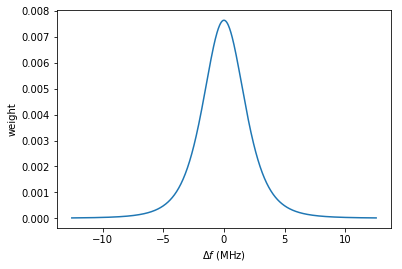

In [8]:
holes = False #set to true if you want to include holes in your simulation
inhomo = True #do you want inhomogneous broadening

f = np.linspace(-gammaq/2, gammaq/2, nbins )
pdf = tsallis(f, q, gammaq/2/np.pi)


if holes:
    frequency_exclude = gcoll/2/np.pi
    exclude_width = 0.2 #FWHM

    indf, freq = find_nearest(f, frequency_exclude)
    scale = pdf[indf]

    toex = cauchy(f, frequency_exclude, exclude_width, -scale)+cauchy(f, -frequency_exclude, exclude_width, -scale)
    #toex2 = cauchy(f, 0, exclude_width, -pdf[int(len(f)/2)])
    pdf = pdf+toex

pdf = np.clip(pdf, 0, max(pdf) )   
    
spdf = sum(pdf)
pdf = pdf/spdf    

if not inhomo:
    pdf = np.zeros(np.shape(pdf))
    pdf[int(nbins/2)] = 1
    
spins = f + deltas#draw samples according to distribution
gs = np.sqrt(pdf)*gcoll
plt.figure()
plt.plot(f, pdf)
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight');
#%qtconsole

In [9]:
def func(a, eta, deltdrive, g=None):
    if g is None:
        g = gs
    spins2 = 2*np.pi*(spins)+deltdrive

    s1 = 2*a*g**2
    s2 = gpar+2*gperp+2*1j*spins2
    s3 = 8*(gpar+2*gperp)*np.abs(a)**2*g**2
    s4 = gpar*((gpar+2*gperp)**2+4*spins2**2)
    
    s = s1/(s2*(-1-s3/s4))
    
    ret = -1j*a*deltdrive + eta - a*kappa + np.sum(s)
    return ret.real, ret.imag

def a_steady(eta, deltadrive, init):

    def equations(x):
        ar, ai = x
        return func(ar+1j*ai, eta, deltadrive)
    ar, ai = fsolve(equations, init)

    return ar, ai

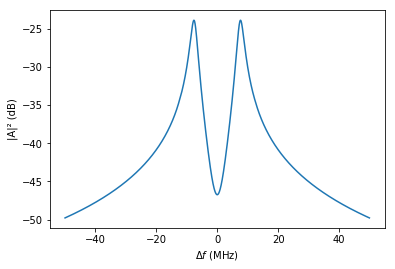

In [10]:
initsteady = (0.1,0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)');
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

In [11]:
#this is as optimized as possible using numpy slicing so calling this function SHOULD be very fast
ret = np.zeros(nbins*2+1, dtype=complex)

#@jit
def mbes(Y, t, eta):
    ret[0] = -kappa*Y[0]-1j*deltac*Y[0]+np.sum(gs*Y[1::2])+eta
    ret[1::2] = -(gperp+gpar/2 + 1j*(spins*2*np.pi+deltac))*Y[1::2]+gs*Y[2::2]*Y[0]
    ret[2::2] = -gpar*(1+Y[2::2])-2*gs*(Y[1::2]*np.conj(Y[0])+np.conj(Y[1::2])*Y[0])
    return ret

#%%timeit gives
#10000 loops, best of 3: 45 µs per loop
#for 800 spins it becomes ~70µs. This is probably not the bottleneck


#this function is a lot slower, so be careful when using it
#@jit
def mbes_soc(Y, t, ilist, qlist, tlist):
    idx = find_nearest_sorted_left(tlist, t)
    ret[0] = -kappa*Y[0]-1j*deltac*Y[0]+np.sum(gs*Y[1::2])+ilist[idx]-1j*qlist[idx]
    ret[1::2] = -(gperp+gpar/2 +1j*(spins*2*np.pi+deltac))*Y[1::2]+gs*Y[2::2]*Y[0]
    ret[2::2] = -gpar*(1+Y[2::2])-2*gs*(Y[1::2]*np.conj(Y[0])+np.conj(Y[1::2])*Y[0])
    return ret

def mbes_soc2(Y, t, fcomps, wgrund,  offseti, offsetq):
    pi = (pulse_rwa(t, [wgrund, fcomps[:,0]])) + offseti
    pq = (pulse_rwa(t, [wgrund, fcomps[:,1]])) + offsetq
    ret[0] = -kappa*Y[0]-1j*deltac*Y[0]+np.sum(gs*Y[1::2])+pi-1j*pq
    ret[1::2] = -(gperp+gpar/2 +1j*(spins*2*np.pi+deltac))*Y[1::2]+gs*Y[2::2]*Y[0]
    ret[2::2] = -gpar*(1+Y[2::2])-2*gs*(Y[1::2]*np.conj(Y[0])+np.conj(Y[1::2])*Y[0])
    return ret



In [12]:
def do_calculation(drive, tlistpump, tlistafter, init):

    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes, init, tlistpump, args=(drive,), full_output=True)
    init2 = asolpump[-1,:]
    asoldecay = odeintz(mbes, init2, tlistafter, args=(0,))
    
    #this is necessary because we are clustering the spins
    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    return asolpump, asoldecay, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...

    
def do_calculation_soc_awg(ilist, qlist, tlistpump, tlistafter, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes_soc, init, tlistpump, args=(ilist, qlist, tlistpump), full_output=True)
    init2 = asolpump[-1,:]
    asoldecay = odeintz(mbes, init2, tlistafter, args=(0,))

    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    
    return asolpump, asoldecay, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...
    
def do_calculation_soc_pump_only_awg(ilist, qlist, tlist, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    it doesn't use a decay afterwards such that it is better for genetic algorithm
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran
    asol, infodict = odeintz(mbes_soc, init, tlist, args=(ilist, qlist, tlist), full_output=True)
    
    asol[:,2::2] = asol[:,2::2]*pdf
    asol[:,1::2] = asol[:,1::2]*pdf
    
    return asol, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...   
    
    
def do_calculation_soc(fourier, wgrund,  offseti, offsetq, tlistpump, tlistafter, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes_soc2, init, tlistpump, args=(fourier, wgrund, offseti, offsetq), full_output=True)
    init2 = asolpump[-1,:]
    asoldecay = odeintz(mbes, init2, tlistafter, args=(0,))

    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    
    return asolpump, asoldecay, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...
    
def do_calculation_soc_pump_only(fourier, wgrund,  tlist, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    it doesn't use a decay afterwards such that it is better for genetic algorithm
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran
    asol, infodict = odeintz(mbes_soc2, init, tlist, args=(fourier, wgrund, offseti, offsetq), full_output=True)
    
    asol[:,2::2] = asol[:,2::2]*pdf
    asol[:,1::2] = asol[:,1::2]*pdf
    
    return asol, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...

# SOC pulses

In [13]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse

In [14]:
pumptime = 5*np.pi/gcoll
decaytime = 200e-3
dt = 4e-3 #The time resolution of the AWG. Don't change that because the solution of the MBEs are written in a way that use that as time resolution
numsteps = int(pumptime/dt)
tlist = np.arange(0,pumptime+dt,dt)
tlistdecay = np.arange(0, decaytime+dt, dt)

# test time it takes to calculate


init = np.ones(nbins*2+1)*(-1)
init[0] = 0
init[1::2] = 0

### Calibrate power

In [15]:
pulsei = np.ones((len(tlist)))

pin = np.arange(-20, 0,0.1)
aref = 200

alos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))

for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = do_calculation(dr, tlist, tlistdecay, init)
    alos[ctr, : ] = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack((np.real(asolpump[:,2::2]), np.real(asoldecay[:,2::2])))
    small[ctr, :, :] = np.vstack((np.real(asolpump[:,1::2]), np.real(asoldecay[:,1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(np.sum(asoldecay[:, 1::2], axis=1))))

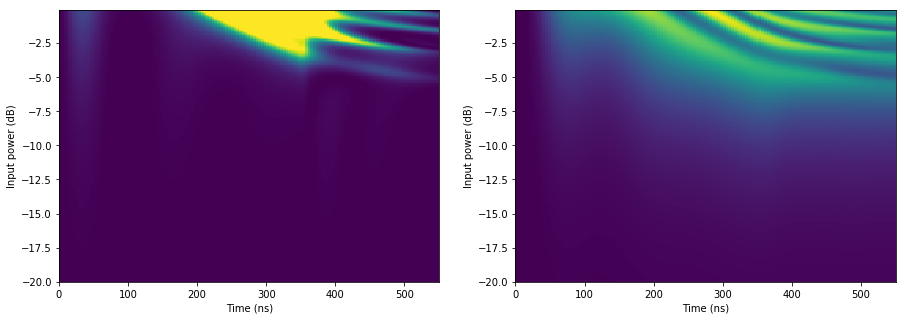

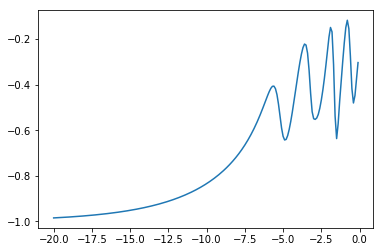

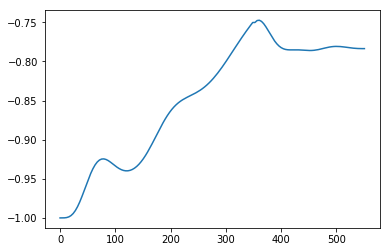

In [16]:
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.pcolor(tplot, pin, alos, vmin=0, vmax=60)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)');

ax2.pcolor(tplot, pin, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)');

plt.figure()
idx = min(range(len(tplot)), key=lambda i: abs(tplot[i]-50*1000))
plt.plot(pin, szlos[:, idx])
plt.figure()
plt.plot(tplot, szlos[110, :])

In [17]:
"""szcount = 0
for i in range(len(tplot)):
    fi = plt.figure()
    pl = 110-15
    plt.plot(f, szall[pl,i,:]/pdf)
    plt.plot(f, small[pl,i,:]/pdf,'k')
    plt.xlabel('Detuning (MHz)')
    plt.ylabel('Inversion')
    plt.ylim([-1,1])
    tr = np.linspace(f[0], f[-1], len(tplot))
    szcount += sum(abs(small[pl, i, 350]/pdf[350]))
    plt.plot(tr, (-1+2*alos[pl, :]/max(abs(alos[pl,:]))))
    plt.plot(tr[i], (-1+2*alos[pl,i]/max(abs(alos[pl,:]))), 'ro')
    plt.text(5,0.5, szcount)
    fi.savefig('/home/andreas/Diverses/tmpimg/%s.png'%i)
    plt.close('all')""";

### Linear Rabi oscillations

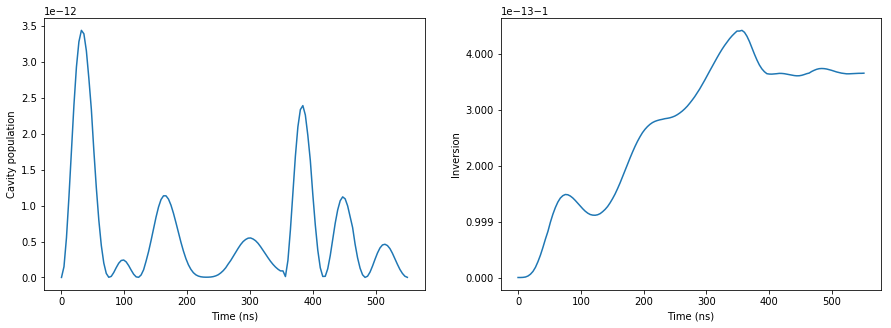

In [18]:
alos = np.zeros((len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))

asolpump, asoldecay, infodict = do_calculation(.0001, tlist, tlistdecay, init)
alos = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
szlos = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
                  
                  
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(tplot, alos)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Cavity population');

ax2.plot(tplot, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Inversion');

## Check maximum amplitude for pulses

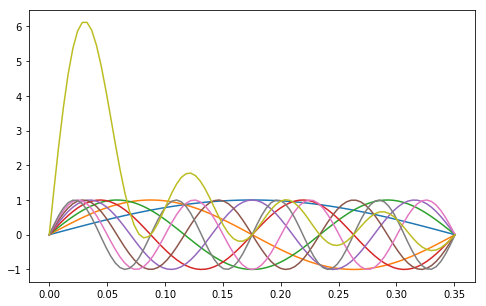

In [19]:
number_fcp = 6
ttest = np.linspace(0,pumptime,numsteps)
wgrund = np.pi/ttest[-1]
sumsin = np.zeros((number_fcp, len(ttest)))

fig, ax = plt.subplots(1,1, figsize=(8,5))

for i in range(number_fcp):
    sumsin[i, :] = np.sin(wgrund*ttest*(i+1))
    ax.plot(ttest, sumsin[i,:])
ax.plot(ttest, np.sum(sumsin, axis=0))
maxfourier = max(np.sum(sumsin, axis=0))

In [26]:
def calculate_fitness(num, fourier=[], wgrund=np.pi, scale=1., timelist=[], timelistdecay = [], target_time = 50e-3):
    init = np.ones(nbins*2+1)*(-1)
    init[0] = 0
    init[1::2] = 0
    solutionpump, solutiondecay, infodict = do_calculation_soc(fourier[num], wgrund, scale, timelist, timelistdecay, init)
    idx = np.abs(timelistdecay - target_time).argmin()
    return ((1+np.real(np.sum(solutiondecay[:, 2::2], axis=1)[idx]))/2, np.vstack((solutionpump, solutiondecay)))

In [27]:
class GeneticAlgorithmSmooth:
    
    def __init__(self):
        self.tp = np.arange(0,pumptime+dt,dt)
        self.td = np.arange(0, decaytime+dt, dt)
        self.populationsize = 300
        self.mutationrate = 0.7
        self.number_fcp = number_fcp
        self.max_ampl = aref/2
        self.max_t_ampl = aref
        self.target_time_decay = np.pi/gcoll/2 #when after switching off the pulse the inversion should be maximum
        self.target_fitness = 0.95
        self.keep_best = 6
        self.p = FloatProgress(min=0, max=self.populationsize)
        self.display = display(self.p, display_id='a')
        self.textid = str(uuid.uuid4())
        self.progress_text = display(Markdown(""), display_id='b')
        self.view = view
        self.rc = rc
        self.wgrund = np.pi/self.tp[-1]
        self.average_fitness = []
        self.best_fitness = []
        self.base_progress = qutip.ui.BaseProgressBar(self.populationsize)

        
    def main(self, filename=None):
        populationPulse = np.zeros((self.populationsize, len(self.tp), 2))
        populationFourier = np.zeros((self.populationsize, self.number_fcp, 2))
        populationFitness = np.zeros((self.populationsize))
        populationSolution = np.zeros((self.populationsize, len(self.tp)+len(self.td), 2*nbins+1), dtype=complex)
        populationFourier2 = np.zeros((self.populationsize, self.number_fcp, 2))

        best_fitness = 0
        
        
        for k in range(self.populationsize):
            pulsei = np.ones(1)*(self.max_t_ampl+3)
            pulseq = pulsei.copy()
            while max(np.sqrt(pulsei**2+pulseq**2)) > self.max_t_ampl:
                frand = np.random.uniform(-self.max_ampl, self.max_ampl, (self.number_fcp, 2))
                populationFourier[k, :, :] = frand
                pulsei = pulse_rwa(self.tp, [self.wgrund, frand[:,0]])
                pulseq = pulse_rwa(self.tp, [self.wgrund, frand[:,1]])
            
        ctr = 0
        sortkeys = None
        diffbest = 0
        handle = None
        last_gen = -1
        t = datetime.datetime.now()
        filename_save = "/home/andreas/Physik/genetic/genetic_%s"%t.strftime("%Y-%m-%d %H:%M:%S")
        
        disp1 = display(Markdown(""), display_id='0')
        disp2 = display(Markdown(""), display_id='1')
        disp3 = display(Markdown(""), display_id='2')
        disp4 = display(Markdown(""), display_id='3')
        disp5 = display(Markdown(""), display_id='4')
        
        if filename is not None:
            filename_save = filename
            data = scipy.io.loadmat(filename)
            sortkeys = populationFitness.argsort()
            bestindex = sortkeys[-1]
            for k in range(self.populationsize):
                if k==bestindex:
                    populationFourier[k,:,:] = data['fourier']
                else:
                    pulsei = np.ones(1)*(self.max_t_ampl+3)
                    pulseq = pulsei.copy()
                    while max(np.sqrt(pulsei**2+pulseq**2)) > self.max_t_ampl:
                        frand = np.random.uniform(-self.max_ampl, self.max_ampl, (self.number_fcp, 2))
                        populationFourier[k, :, :] = frand
                        pulsei = pulse_rwa(self.tp, [self.wgrund, frand[:,0]])
                        pulseq = pulse_rwa(self.tp, [self.wgrund, frand[:,1]])
            populationPulse[bestindex, :, :] = data['pulse']
            populationSolution[bestindex, :, :] = data['solution']
            populationFitness = data['fitness'][0,:]
            self.best_fitness = list(data['best_fitness_evol'][0,:])
            self.average_fitness = list(data['average_fitness_evol'][0,:])
            ctr = int(data['generation'][0])+1
            
            best_fitness = populationFitness.max()
            del data
            handle = self.plot_stuff(np.real(np.sum(populationSolution[bestindex,:, 2::2], axis=1)), populationSolution[bestindex, :, 0], populationPulse[bestindex, :, 0], populationPulse[bestindex, :, 1], handle)
            gc.collect()
            
        
        
        while best_fitness < self.target_fitness:
            disp1.update(Markdown("Generation %i: Working - Highest fitness so far is %.9f" %(ctr - 1, populationFitness.max())))
            disp2.update(Markdown("Generation %i: Average fitness: %.9f"%(ctr - 1, np.mean(populationFitness))))
            disp3.update(Markdown("Last improvement was in generation %i by %.4E"%(last_gen, diffbest)))
            disp4.update(Markdown("Generation %i: Idle - Trying to improve best member of generation"%(ctr-1)))
            self.average_fitness.append(float(np.mean(populationFitness)))
            self.best_fitness.append(populationFitness.max())
            
            gc.collect()
            
            
            
            for num in range(self.populationsize):
                pulsei = np.ones(1)*(self.max_t_ampl+3)
                pulseq = pulsei.copy()
                while max(np.sqrt(pulsei**2+pulseq**2)) > self.max_t_ampl:
                    if sortkeys is None:
                        populationPulse[num, :, 0] = pulse_rwa(self.tp, [self.wgrund, populationFourier[num, :, 0]])
                        populationPulse[num, :, 1] = pulse_rwa(self.tp, [self.wgrund, populationFourier[num, :, 1]])
                    elif (num not in sortkeys[-self.keep_best:]):
                        fcpin = populationFourier[num, :, 0]
                        fcpqn = populationFourier[num, :, 1]
                        fcpi, fcpq = self.mutate(fcpin, fcpqn, self.mutationrate)
                        populationFourier[num, :, 0] = fcpin
                        populationFourier[num, :, 1] = fcpqn
                        populationPulse[num, :, 0] = pulse_rwa(self.tp, [self.wgrund, fcpin])
                        populationPulse[num, :, 1] = pulse_rwa(self.tp, [self.wgrund, fcpqn])
                    pulsei = pulse_rwa(self.tp, [self.wgrund, populationFourier[num, :,0]])
                    pulseq = pulse_rwa(self.tp, [self.wgrund, populationFourier[num, :,1]])
                    
            
            success = False
            if sortkeys is not None:
                vals = np.delete(np.arange(self.populationsize), sortkeys[-self.keep_best:], 0)
            else:
                vals = np.arange(self.populationsize)

            while not success:
                try:
                    ret = self.do_the_parallel_stuff(vals, 
                                                    task_kwargs=dict(wgrund=self.wgrund, fourier=populationFourier, timelist=self.tp, timelistdecay=self.td, target_time = self.target_time_decay));
                    success = True
                    signal.alarm(0)
                except (RuntimeError, ParallelTimeoutException):
                    self.rc = ipyparallel.Client(profile='parallel')
                    self.view = self.rc.direct_view()
                    self.redo_namespace()
                    gc.collect()
                    
            for j, k in enumerate(vals):
                populationFitness[k] = ret[j][0]
                populationSolution[k, :, :] = ret[j][1]
            del ret
            gc.collect()
            sortkeys = populationFitness.argsort() 
            bestindex = sortkeys[-1]
            
            disp1.update(Markdown("Generation %i: Idle - Highest fitness so far is %.9f" %(ctr, populationFitness.max())))
            disp2.update(Markdown("Generation %i: Average fitness: %.9f"%(ctr, np.mean(populationFitness))))
            
            if populationFitness.max() > best_fitness:
                handle = self.plot_stuff(np.real(np.sum(populationSolution[bestindex,:, 2::2], axis=1)), populationSolution[bestindex,:, 0], populationPulse[bestindex, :, 0], populationPulse[bestindex, :, 1], handle)
            
            
            bestfcompsi = populationFourier[bestindex, :,0]
            bestfcompsq = populationFourier[bestindex, :,1]
            for num in range(self.populationsize):
                populationFourier2[num, :, 0] = bestfcompsi
                populationFourier2[num, :, 1] = bestfcompsq
                pulsei = np.ones(1)*(self.max_t_ampl+3)
                pulseq = pulsei.copy()
                random_index = random.randrange(0,2*self.number_fcp)
                changei = True
                while max(np.sqrt(pulsei**2+pulseq**2)) > self.max_t_ampl:
                    if random_index > len(bestfcompsi)-1:
                        random_index = random_index - self.number_fcp
                        changei = False
                    if changei:
                        kval = self.max_ampl + 2
                        while abs(kval) >= self.max_ampl:
                            kval = bestfcompsi[random_index]*np.random.uniform(0.9, 1.1)
                        populationFourier2[num, random_index, 0] = kval
                    else:
                        kval = self.max_ampl + 2
                        while abs(kval) >= self.max_ampl:
                            kval = bestfcompsq[random_index]*np.random.uniform(0.9, 1.1)
                        populationFourier2[num, random_index, 1] = kval
                    
                    pulsei = pulse_rwa(self.tp, [self.wgrund, populationFourier2[num,:,0]])
                    pulseq = pulse_rwa(self.tp, [self.wgrund, populationFourier2[num,:,1]])
            
            success = False
            disp4.update(Markdown("Generation %i: Working - Trying to improve best member of generation"%(ctr)))
            while not success:
                try:
                    ret = self.do_the_parallel_stuff(np.arange(self.populationsize), 
                                                    task_kwargs=dict(wgrund=self.wgrund, fourier=populationFourier2, timelist=self.tp, timelistdecay=self.td, target_time = self.target_time_decay))
                    success = True
                    signal.alarm(0)
                except (RuntimeError, ParallelTimeoutException):
                    self.rc = ipyparallel.Client(profile='parallel')
                    self.view = self.rc.direct_view()
                    self.redo_namespace()
                    gc.collect()
            
            best_improve = 0
            idxbest = -1
            for k in range(self.populationsize):
                if ret[k][0] > best_improve:
                    best_improve = ret[k][0]
                    idxbest = k
            
            if best_improve > populationFitness[bestindex]:
                disp5.update(Markdown("Generation %i: Improvement. New best fitness: %.9f"%(ctr, best_improve)))
                populationFitness[bestindex] = ret[idxbest][0]
                populationSolution[bestindex, :, :] = ret[idxbest][1]
                populationFourier[bestindex, :, :] = populationFourier2[idxbest, :, :]
                populationPulse[bestindex, :, 0] = pulse_rwa(self.tp, [self.wgrund, populationFourier2[idxbest, :, 0]])
                populationPulse[bestindex, :, 1] = pulse_rwa(self.tp, [self.wgrund, populationFourier2[idxbest, :, 1]])
            else:
                disp5.update(Markdown("Generation %i: No improvement"%(ctr)))
            del ret
            
            gc.collect()
            
            
            if populationFitness.max() > best_fitness:
                handle = self.plot_stuff(np.real(np.sum(populationSolution[bestindex,:, 2::2], axis=1)), populationSolution[bestindex,:, 0], populationPulse[bestindex, :, 0], populationPulse[bestindex, :, 1], handle)
                savedict = {'wgrund': self.wgrund, 'time': self.tp, 'timedecay': self.td, 'fourier': populationFourier[bestindex, :, :], 'pulse':populationPulse[bestindex, :, :], 'solution': populationSolution[bestindex, :, :], 'fitness': populationFitness[sortkeys], 'nbins':nbins, 'gammaq':gammaq,'gpar': gpar, 'gperp':gperp, 'deltac': deltac, 'deltas':deltas, 'kappa':kappa,'gs':gs, 'generation':ctr, 'best_fitness_evol':self.best_fitness, 'average_fitness_evol':self.average_fitness}
            
                pulseforsave = np.zeros((len(self.tp), 3))
                pulseforsave[:,0] = self.tp
                pulseforsave[:,1:] = populationPulse[bestindex, :,:]
                savedict2 = {'wgrund': self.wgrund, 'nfreqs':self.number_fcp, 'puls': pulseforsave, 'a1': np.hstack((populationFourier[bestindex, :, 0], populationFourier[bestindex, :, 1]))}
                scipy.io.savemat(filename_save, savedict)
                scipy.io.savemat(filename_save+'_simple', savedict2)
                del savedict

                last_gen = ctr
                diffbest = populationFitness.max()-best_fitness
                best_fitness = populationFitness.max()
                
            gc.collect()
            
            ctr = ctr + 1
            populationFourier[:, :, :] = self.crossover(populationFourier, populationFitness)

    
    
    def mutate(self, fourierI, fourierQ, mutationrate):
        #maxi = max(abs(fourierI))
        #maxq = max(abs(fourierQ))
        newfourierI = fourierI.copy()
        newfourierQ = fourierQ.copy()
        for iidx, pi in enumerate(fourierI):
            if np.random.uniform() > (1-mutationrate):
                newfourierI[iidx] = np.random.uniform(-self.max_ampl, self.max_ampl)
        for iidx, pq in enumerate(fourierQ):
            if np.random.uniform() > (1-mutationrate):
                newfourierQ[iidx] = np.random.uniform(-self.max_ampl, self.max_ampl)
        return newfourierI, newfourierQ
        
    def crossover(self, populationFourier, populationFitness):
        lf = populationFitness/sum(populationFitness)
        sortkeys = populationFitness.argsort()
        newpop = np.zeros(np.shape(populationFourier))
        for i, pop in enumerate(populationFourier):
            if i in sortkeys[-self.keep_best:]:
                newpop[i, :, :] = pop[:,:]
            else:
                idx1, idx2 = np.random.choice(range(self.populationsize), 2, p=lf, replace=False)
                f1 = populationFitness[idx1]
                f2 = populationFitness[idx2]
                factor1 = f1/(f1+f2)
                factor2 = f2/(f1+f2)
                fcpi1 = populationFourier[idx1, :, 0]
                fcpi2 = populationFourier[idx2, :, 0]
                fcpq1 = populationFourier[idx1, :, 1]
                fcpq2 = populationFourier[idx2, :, 1]
                fcpinew = (fcpi1*factor1+fcpi2*factor2)
                fcpqnew = (fcpq1*factor1+fcpq2*factor2)
                newpop[i, :, 0] = fcpinew
                newpop[i, :, 1] = fcpqnew
        return newpop
    
    def redo_namespace(self):
        lex = ["import numpy as np",
                "from scipy import integrate",
                "import math",
                "import time",
                "import ipyparallel"]

        [self.view.execute(k) for k in lex]
        self.view.push(dict(spins=spins, pdf=pdf, nbins=nbins, gammaq=gammaq, gpar=gpar, gperp=gperp, deltac=deltac, deltas=deltas, 
                  kappa=kappa, gs=gs))
        self.view.execute("ret = np.zeros(nbins*2+1, dtype=complex)")
        self.view.push(dict(find_nearest_sorted = find_nearest_sorted, find_nearest_sorted_left = find_nearest_sorted_left, pulse_rwa = pulse_rwa, odeintz = odeintz, do_calculation_soc = do_calculation_soc, mbes_soc = mbes_soc, mbes_soc2 = mbes_soc2, mbes = mbes, do_calculation_soc_awg  = do_calculation_soc_awg, do_calculation_soc_pump_only_awg = do_calculation_soc_pump_only_awg, do_calculation_soc_pump_only = do_calculation_soc_pump_only))
    
    
    def do_the_parallel_stuff(self, values, task_args=tuple(), task_kwargs=None):
        signal.alarm(10*60)
        n = len(values)
        counter = 0
        ret = None
        self.p.value = 0
        self.base_progress.start(len(values))
        ar_list = []
        res_list = [{'data':[], 'assigned': None, 'done':False, 'value':k} for k in values]
        worker_list = [{'working': False, 'worker':worker, 'res':[]} for worker in self.rc]
        self.redo_namespace()
        while True:
            counter_res = 0
            for ctrres, res in enumerate(res_list):
                if res['assigned'] is None:
                    for ctreng, engine in enumerate(worker_list):
                        if not engine['working']:
                            worker_list[ctreng]['res'] = engine['worker'].apply_async(calculate_fitness, res['value'], *task_args, **task_kwargs)
                            res_list[ctrres]['assigned'] = ctreng
                            worker_list[ctreng]['working'] = True
                            break
                else:
                    if res['done']:
                        counter_res = counter_res + 1
                    else:
                        engine = worker_list[res['assigned']]
                        if engine['working']:
                            if engine['res'].done():
                                res_list[ctrres]['data'] = engine['res'].get()
                                counter = counter + 1
                                try:
                                    self.p.value += 1
                                    lbl = ("Elapsed time: %s. " % self.base_progress.time_elapsed() +
                   "Est. remaining time: %s." % self.base_progress.time_remaining_est(self.p.value/self.populationsize))
                                    self.progress_text.update(Markdown(lbl))
                                except:
                                    pass
                                res_list[ctrres]['done'] = True
                                worker_list[res['assigned']]['working'] = False

            if counter_res == len(values): break
            time.sleep(0.5)
        self.rc.purge_everything()
        self.view.results.clear()
        self.rc.results.clear()
        self.rc.metadata.clear()
        self.rc.clear(targets='all')
        self.p.value += 1
        lbl = "Elapsed time: %s" % self.base_progress.time_elapsed()
        self.progress_text.update(Markdown(lbl))
        ret_arr = []
        for k in values:
            for res in res_list:
                if res['value'] == k:
                    ret_arr.append(res['data'])
                    break
        return ret_arr

    
    def plot_stuff(self, szsol, asol, pi, pq, handle=None):
        fig, ((ax1, ax0), (ax2, ax3)) = plt.subplots(2,2,figsize=(15,10))
        pos1 = ax1.get_position()
        pos2 = ax2.get_position()
        pos3 = ax3.get_position()
        pos1n = [(pos2.x0+pos3.x0)/2, pos1.y0,  pos1.width, pos1.height] 
        ax0.remove()
        ax1.plot(self.tp*1000, pi, 'b-')
        ax1.plot(self.tp*1000, pq, 'g-')
        ax1.plot(self.tp*1000, np.sqrt(pi**2+pq**2), 'k--')
        ax1.set_ylabel("Amplitude (a.u.)")
        ax1.set_xlabel("Time (ns)")        
        ax2.plot(self.tp*1000, (1+szsol[:len(self.tp)])/2, 'r-')
        ax2.plot(self.td*1000+self.tp[-1]*1000, (1+szsol[len(self.tp):])/2, 'k-')
        ax2.set_ylabel("Inversion")
        ax2.set_xlabel("Time (ns)")
        ax3.plot(self.tp*1000, abs(asol[:len(self.tp)])**2, 'g-')
        ax3.plot(self.td*1000+self.tp[-1]*1000, abs(asol[len(self.tp):])**2, 'm-')
        ax3.set_ylabel("|A|²")
        ax3.set_xlabel("Time (ns)")
        ax1.set_position(pos1n)
        plt.close('all')
        if not handle:
            handle = display(fig, display_id='plot')
        else:
            handle.update(fig)
        return handle

FloatProgress(value=0.0, max=300.0)

Elapsed time:  84.68s. Est. remaining time: 00:04:10:36.

Generation 153: Working - Highest fitness so far is 0.548046204

Generation 153: Average fitness: 0.525645251

Last improvement was in generation 93 by 2.9142E-08

Generation 153: Idle - Trying to improve best member of generation

Generation 153: No improvement

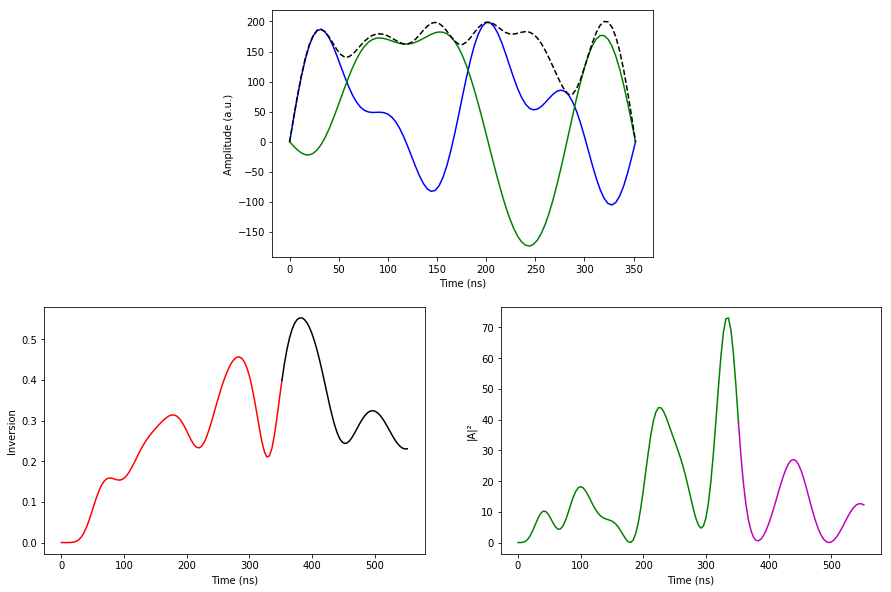

In [ ]:
gg = GeneticAlgorithmSmooth()
gg.redo_namespace()
gg.main()